# Using BERT to Classify Emotion in Text

This project beg for the Udacity Machine Learning Engineer Nanodegree is described in more detail in this <a href="https://drive.google.com/open?id=1ALVUnQS1eLqQHcMiU0uMD2xOnCuGMe8x">project proposal</a>.

## Project Summary 

As a Psychologist who is interested in analyzing the content and outcomes of mental health treatment, text data is very important. Most of the content of clinical documentation is currently stored in text, and the content of psychotherapy could be either manually transcribed or automatically via speech-to-text. Thus, I'm very interested modern Natural Language Processing )(NLP) techniques to classify the content of text.

In this project, I'm attempting to see if a modern NLP technique called <a href="https://arxiv.org/pdf/1810.04805.pdf"> "Bidirectional Encoder Representations from Transformers" (BERT)</a> can be used to improve upon previous attempts in the literature to classify emotion from text.

The study I am using as a baseline is entitled <a href="https://www.aclweb.org/anthology/C18-1179.pdf">"An Analysis of Annotated Corpora for Emotion Classification in Text"</a>. This study looked at a number of different text corpora which had been labeled with expressed emotion. The dataset I selected from the study is called <a href="https://arxiv.org/pdf/1710.03957.pdf">"DailyDialog"</a>. I selected this dataset for a few reasons:

1. I am intending to do a within corpus prediction, and this dataset was noted as one of the best for that purpose in the study. They were able to achieve an F1 score of .71, which was one of the higher within corpus results.
2. It contains content that is meant to represent usual discussions between individuals, back and forth, which would be a better facsimile of a therapy session.
3. It was readily and publicly available for download.
4. Upon initial review, it looked quite clean and well documented, requiring a minimum amount of data transformation and cleaning.
5. It contains multiple labeled emotions (6 discrete emotions and "no emotion"), which makes it a more challenging prediction task than simple positive or negative binary emotion.

## Goal

My goal is to use BERT (or a BERT-like model) to predict the labeled emotion for each sentence in the dataset. I hope to exceed the study's F1 score of .71 and will be using F1 because the dataset is relatively unbalanced in its class representation, meaning pure accuracy would not be ideal.

## Loading in the Data and Initial Exploration

The data is stored in two separate raw text files (dialogues_text.txt and dialogues_emotion.txt). The former contains the text of the conversations, while the latter contains the labeled emotions.

The emotion classes are labeled numerically:

- 0: 'no emotion'
- 1: 'anger' 
- 2: 'disgust'
- 3: 'fear' 
- 4: 'happiness' 
- 5: 'sadness'
- 6: 'surprise'

In the cell below I load in the two files to show how the data is represented. As you can see, each sentence is separated by a marker "__eou__" and each conversation is separated by a new line.

For emotions, each number is an emotion label corresponding to a single sentence in the text file, separated by spaces, and with conversations again split by a new line.

In [1]:
#Importing required libraries.
import io
import collections
import numpy as np
import re
import sklearn

from simpletransformers.classification import ClassificationModel

#Load in each text file
dialogues_text = open("dialogues_text.txt", encoding="utf-8").read()
dialogues_emotion = open("dialogues_emotion.txt", encoding="utf-8").read()

print("Sample Text: \n" + dialogues_text[0:1000] + "\n\n")
print("Sample Emotion Labels: \n" + dialogues_emotion[0:15])

Sample Text: 
The kitchen stinks . __eou__ I'll throw out the garbage . __eou__
So Dick , how about getting some coffee for tonight ? __eou__ Coffee ? I don ’ t honestly like that kind of stuff . __eou__ Come on , you can at least try a little , besides your cigarette . __eou__ What ’ s wrong with that ? Cigarette is the thing I go crazy for . __eou__ Not for me , Dick . __eou__
Are things still going badly with your houseguest ? __eou__ Getting worse . Now he ’ s eating me out of house and home . I ’ Ve tried talking to him but it all goes in one ear and out the other . He makes himself at home , which is fine . But what really gets me is that yesterday he walked into the living room in the raw and I had company over ! That was the last straw . __eou__ Leo , I really think you ’ re beating around the bush with this guy . I know he used to be your best friend in college , but I really think it ’ s time to lay down the law . __eou__ You ’ re right . Everything is probably going to come 

## Initial Data Manipulation

The data needs to be both transformed and loaded into a Pandas DataFrame for the eventual model training. We are looking for the eventual model training, the data needs to be in a DataFrame with two columns, one entitled "text", which has one row per sentence, and one entitled "label", with each label represented by a number.

Our data is relatively close to that format. In order to get the text data into one sentence per line, the data will first have all newlines removed, as they are irrelevant to this analysis, and then the data will be split based on the special "\_\_eou\_\_" character which represents the end of a sentence.

For the emotion labels, again all newline characters will be removed, and then the data will simply be split by spaces.

These will both be loaded into separate arrays and then put together into the final dataframe.

As you can see below, we end up with 102981 sentences labeled with emotions.

In [2]:
#Importing required libraries.
import pandas as pd

#load both files into arrays, stripping out the new-line characters and splitting.
dialogues_text = open("dialogues_text.txt", encoding="utf-8").read().replace('\n', ' ').split(' __eou__ ')
dialogues_emotion = open("dialogues_emotion.txt", encoding="utf-8").read().replace('\n', '').split(' ')

#After some analysis it was determined that for some reason a single emotion label was missing from the dataset at this point.
#The sentence appeared to have no emotion, and this class is the most common, so would have the least impact on the data,
#so a zero is inserted in the emotion array here.
dialogues_emotion.insert(4632, '0')

print(len(dialogues_text))

#Load both arrays into a single dataframe, remove any rows that have blank sentences and convert the label column to an integer
#from the original string data type.
dialogues_df = pd.DataFrame({'text': dialogues_text, 'labels': dialogues_emotion})
dialogues_df = dialogues_df[dialogues_df.text != '']
dialogues_df.labels = dialogues_df.labels.astype(int)


102981


In [3]:
#Examining the head of the DataFrame, we see that the text and labels loaded correctly.
#The longest sentence is 1412 characters, which may affect the ideal sequence length in our eventual model.
print(dialogues_df.head())
print(dialogues_df.text.map(lambda x: len(x)).max())

                                                text  labels
0                               The kitchen stinks .       2
1                       I'll throw out the garbage .       0
2  So Dick , how about getting some coffee for to...       4
3  Coffee ? I don ’ t honestly like that kind of ...       2
4  Come on , you can at least try a little , besi...       0
1412


# Data Distribution

It's important to take a look at the distribution of the dataset, as imbalanced datasets can sometimes affect certain models, and it definitely impacts the evaluation metric used. If one class is overly represented, for example, and the model just learns to always predict that class, it can score quite well despite having very little predictive power.

In our dataset, as shown below, around 83% of the sentences as labeled with "no emotion". If our model predicted no emotion for every sentence, it would have an accuracy score of 83%, which is not bad, but obviously not a well trained model.

As such, we'll be using the F1 score for this model, which balances valuing precision and recall. In addition, we'll be using the F1 micro score, partially because that is what was used in the original study we are using as a benchmark, and also because it averages the F1 scores achieved for each class, so even very small classes can be equally represented in the final score.

No Emotion: 85573  (83.1%)
Anger: 1022  (1.0%)
Disgust: 353  (0.3%)
Fear: 174  (0.2%)
Happiness: 12885  (12.5%)
Sadness: 1150  (1.117%)
Surprise: 1823  (1.77%)


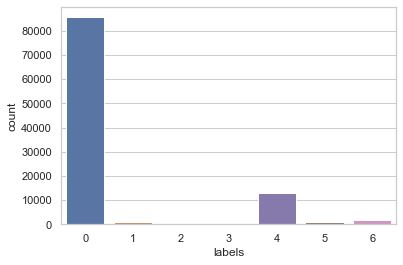

In [4]:
import seaborn as sns

#Calculate the counts of each emotion in the dataset
total_emotions_count = len(dialogues_df.labels)
no_emotion_count = len(dialogues_df[dialogues_df.labels == 0])
anger_count = len(dialogues_df[dialogues_df.labels == 1])
disgust_count = len(dialogues_df[dialogues_df.labels == 2])
fear_count = len(dialogues_df[dialogues_df.labels == 3])
happiness_count = len(dialogues_df[dialogues_df.labels == 4])
sadness_count =  len(dialogues_df[dialogues_df.labels == 5])
surprise_count =  len(dialogues_df[dialogues_df.labels == 6])

#Print the count along with the precentage of the total
print('No Emotion: ' + str(no_emotion_count) + "  (" + str(round(no_emotion_count/total_emotions_count, 3)*100) + "%)")
print('Anger: ' + str(anger_count) + "  (" + str(round(anger_count/total_emotions_count, 3)*100) + "%)")
print('Disgust: ' + str(disgust_count) + "  (" + str(round(disgust_count/total_emotions_count, 3)*100) + "%)")
print('Fear: ' + str(fear_count) + "  (" + str(round(fear_count/total_emotions_count, 3)*100) + "%)")
print('Happiness: ' + str(happiness_count) + "  (" + str(round(happiness_count/total_emotions_count, 3)*100) + "%)")
print('Sadness: ' + str(sadness_count) + "  (" + str(round(sadness_count/total_emotions_count, 5)*100) + "%)")
print('Surprise: ' + str(surprise_count) + "  (" + str(round(surprise_count/total_emotions_count, 4)*100) + "%)")

#Use seaborn to visualize the distribution.
sns.set(style="whitegrid")
ax = sns.countplot(x="labels", data=dialogues_df)


Next we show the distribution of the lengths of each sentence in number of characters. As we can see, the data is heavily skewed, with a long tail to the right, from the min length of 1 character all the way to 1412 characters in one sentence. The mean is around 60 characters, the median at 47, and the histogram shows that almost all sentences fall within 0 to 200  characters or so.

Mean Length: 60.09
Median Length: 47.0
Max Length: 1412
Min Length: 1


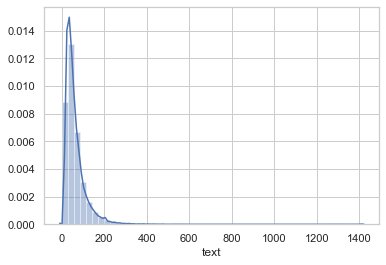

In [5]:
dialogues_length = dialogues_df.text.map(lambda x: len(x))
print("Mean Length: " + str(round(dialogues_length.mean(),2)))
print("Median Length: " + str(dialogues_length.median()))
print("Max Length: " + str(dialogues_length.max()))
print("Min Length: " + str(dialogues_length.min()))

sns.distplot(dialogues_length)

# Preparing the Data into Train and Evaluation Datasets

Now that the data has been tranformed appropriately and we understand the distribution, we need to split the dataset into training, evaluation and test datasets. The original study used 80%/20% train/test split, but I'll be using a 70%/15%/15% train/eval/test split. The eval split will be used to select a model, validate the model performance during training and test hyperparamter tuning. The test set will be held out to only provide final performance metrics. This should give a more accurate expectation of how the model would generalize to new (similar) data and if anything will make it harder for me to achieve the evaluation metrics that the study achieved.

## Data Imbalance

As we saw above, the data is heavily imabalanced. It's important that the proportion of the classes is similar in the training, evaluation and test datasets. So, first I'll split the data by class, then distribute the same proportion of the data randomly to the three datasets.

I've left code below to apply a "none" label to any data beyond the selected train/eval/test data, as this makes it easy to only select .07, .015 and .015 for example to work with 10% of the data for quicker training and testing.

In [6]:
# Splitting train by emotion
# Create dict
by_emotion = collections.defaultdict(list)
for _, row in dialogues_df.iterrows():
    by_emotion[row.labels].append(row.to_dict())
    
# Create split data
final_list = []
np.random.seed(42)
for _, item_list in sorted(by_emotion.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(.70*n)
    n_val = int(.15*n)
    n_test = int(.15*n)
    
    #Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'
    for item in item_list[n_train+n_val+n_test:]:
        item['split'] = 'none'  
    
    # Add to final list
    final_list.extend(item_list)


# Data Pre-Processing

I created a pre-processing function with common methods of processing textual data using regular expressions (making the text data lowercased, inserting spaces around punctionation, any removing any uncommon characters or puncuation), but I didn't end up using it. The data from the study has already had some light pre-processing (spacing etc), applied and the transformers library I will be using I believe performs necessary text pre-processing and tokenization as necessary for BERT-like models by itself.

Instead, I simply split the data using the applied labels above into Train, Eval and Test datasets.

In [7]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [24]:
train_df = pd.DataFrame(filter(lambda x: x['split'] == 'train', final_list))
eval_df = pd.DataFrame(filter(lambda x: x['split'] == 'val', final_list))
test_df = pd.DataFrame(filter(lambda x: x['split'] == 'test', final_list))


print("Train: {}".format(len(train_df)))
print("Eval: {}".format(len(eval_df)))
print("Test: {}".format(len(test_df)))

Train: 72084
Eval: 15443
Test: 15443


# Model Selection and Training

For this project, I decided to use the ["Simple Transformers" library](https://github.com/ThilinaRajapakse/simpletransformers).

After researching BERT a good amount, it seemed like one of the more popular libraries for applying BERT's pre-trained models was the ["Pytorch-Transformers" library by HuggingFace](https://github.com/huggingface/transformers). HuggingFace has apparently done a great job of exposing a number of pre-trained large NLP transformers through a consistent Pytorch interface.

Simple Transformers then took some of the more popular transformers and created an even higher level and user friendly wrapper for the Pytorch-Transformers library. Many BERT, XLNet, NLM, RoBERTa and DistilBERT models are available. The primary benefit of this library is that it's very user friendly, as seen below, only requiring data in a particular format, and then allowing for training, evaluation and prediction in 3 lines of code.

Despite that simplicity, it can handle a number of different application of transformers including multi-class classification (as I'm doing here). In addition, one can pass a number of parameters to the training and evaluation objects to modify hyperparameters such as maximum sequence length, batch size, learning rate and warmup ratio among others.

For my model, I experimented a few different BERT models, beginning with RoBERTa-base, then using BERT cased, XLNet, DistilBERT abd DistilRoBERTa. After running all these models against a 10% subset of the data, I ended up landing on DistilRoBERTa (which is a distilled down, smaller RoBERTa pre-trained model). Being a distilled model, it trains quicker, achieved the highest Matthews Correlation Coefficient (mcc) and also seemed to be more resistant to over-fitting in testing.

# Initial Model Tuning

After training the model using default hyper-parameters, I noticed a few things. Firstly, the training loss appeared to fluctuate wildly. I also noticed that it appeared to achieve a general minimum of loss relatively early in the training, and plateau or even increase. Lastly, on evaluation, I noticed that the model was only predicting 4 of the 7 classes, yet still achieving a high (~ 87%) accuracy and a decent mcc score (~ .47). Given that the dataset nearly 96% of the observations in the dataset are classified as either No Emotion or Happiness, this made sense, but seemed like a distinct case of overfitting to the training data.

In order to diagnose this, I implemented a tool called <a href="https://www.wandb.com/">Weights and Biases</a>, which allows for real-time model evaluation and is supported by the Simple Transformers library. I had originally experimented with TensorBoard, which provided similar metrics, but was not as user-friendly nor did it update seamlessly as the training was occurring. As a test, I initially ran against 10% of the data, 1 epoch only and received the following results:

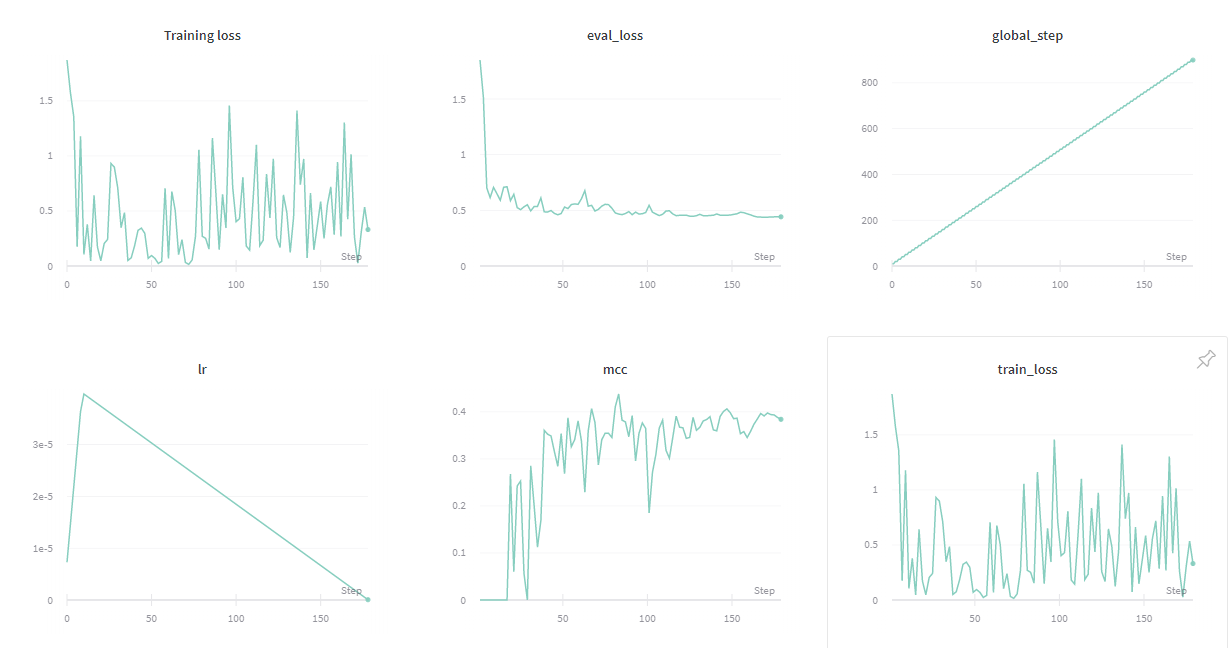

There are a number of things to note here, but the one thing that jumped out in particular was the very large fluctuations in the training loss (and mcc). After doing a bit of research, it seemed like a common cause for this is that the batch size is set too low. When the model is performing adjusting weights through back propagation based on the loss generated from only a few samples of the data, it can swing too far in one direction or the other.

I experimented with a few different settings, but batch rates that were too high (256 for example) caused my poor 8GB GPU to immediately run out of memory. I was able to sometimes get 128 to work, but settled on using 64 for reliability and ran the same training again, but with 10 epochs instead.

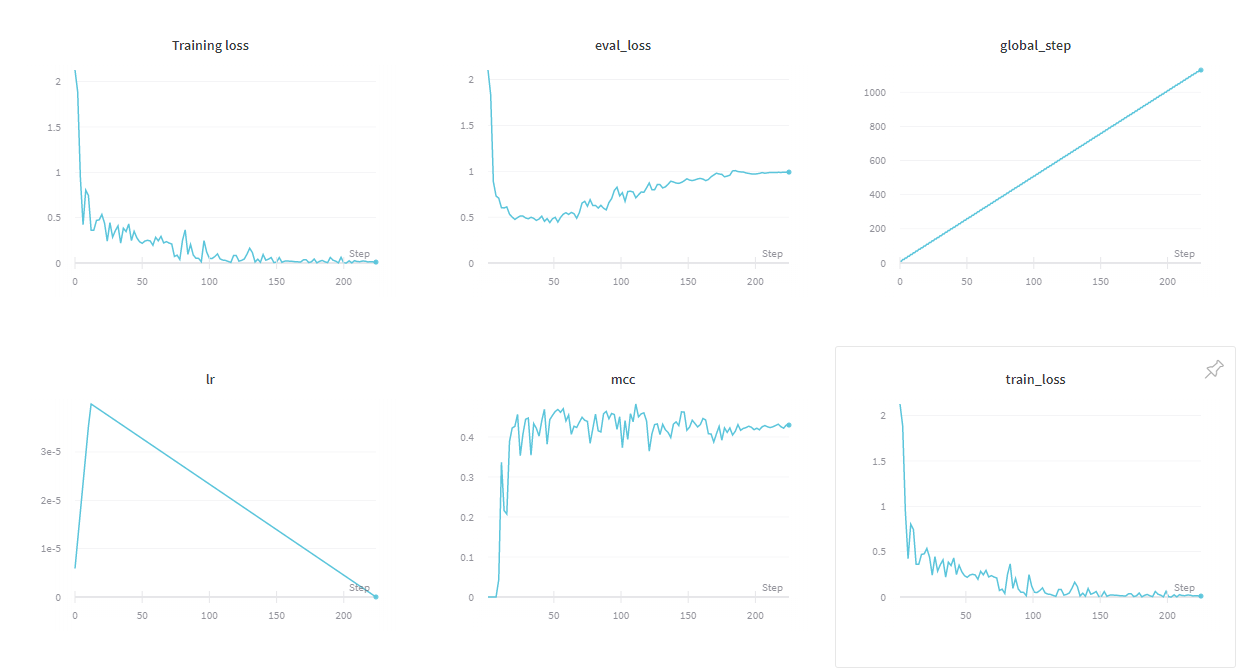

The increase in batch size did appear to address the large fluctuations in training loss and mcc at least somewhat.

As you can see, this tool also illustrated a lot of useful things about this model. First, you can see the learning rate quickly rise up, then slowly drop, which shows the library itself is allowing for a flexible learning rate as it begins to find a minimum which should require less manual tuning of the learning rate parameter.

Secondly, we can see the training loss continue to decrease throughout the 10 epochs, but the loss on the evaluation dataset begin to increase consistently after about 50 steps.

Next, I attempted to address this issue of overfitting to the training set and increase in evaluation loss by implementing Early Stopping. Simple Transformers has parameters to enable early stopping of training once it detects that the evaluation loss has been increasing consistently for a period of time. I could also continue to explore further methods of avoiding overfitting using regularization (such as L2 regularization and dropout).

What follows in the code I used to train this final version of the model, with 3 epochs and early stopping enabled. I also adjusted the Weights and Biases logging to occur only every 100 steps to speed up model training. The Weights and Biases visuals follow immediately after.

# Model Training

In [9]:
# Training arguments
train_args = {
    'evaluate_during_training': True,
    'logging_steps': 100,
    'num_train_epochs': 3,
    'evaluate_during_training_steps': 100,
    'save_eval_checkpoints': False,
    'train_batch_size': 64,
    'eval_batch_size': 64,
    'overwrite_output_dir': True,
    'use_cached_eval_features' : False,
    'reprocess_input_data': True,
    'wandb_project': "visualization-demo",
    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0
}

# Create a ClassificationModel
model = ClassificationModel('roberta', 'distilroberta-base', num_labels=7, args=train_args)

# Train the model
model.train_model(train_df, eval_df=eval_df)

Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Running loss: 1.992396

D:\Anaconda3\envs\transformers\lib\site-packages\torch\optim\lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 1.314169Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.452754

D:\Anaconda3\envs\transformers\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.510146
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.241458
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.455666
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.476173
No improvement in eval_loss for 2 steps.
Training will stop at 3 steps.

Running loss: 0.318784


Running loss: 0.393278
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.243230
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.303280
No improvement in eval_loss for 2 steps.
Training will stop at 3 steps.

Running loss: 0.267167
No improvement in eval_loss for 3 steps.
Training will stop at 3 steps.

Running loss: 0.202245
Patience of 3 steps reached.
Training terminated.

Training of roberta model complete. Saved to outputs/.


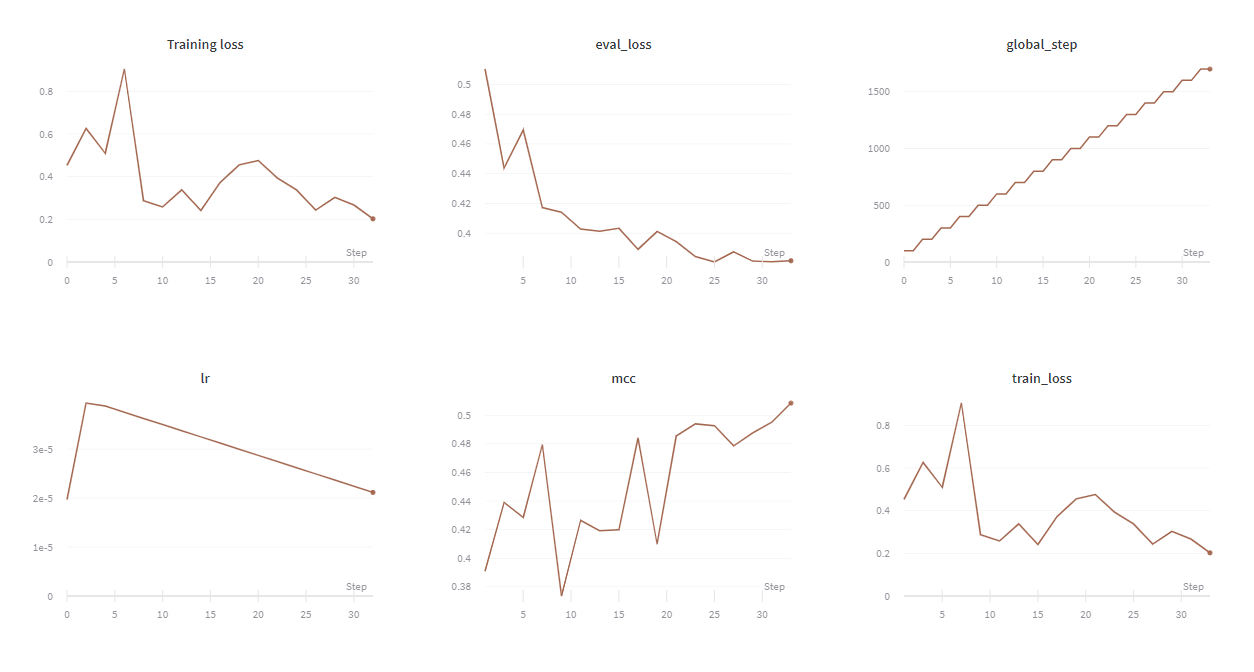

As you can see above, the model stopped early (about 1.5 epochs in) once the evaluation loss started to climb consistently for 3 iterations.

The training loss was at its lowest point, and the mcc had achieved its highest value yet of nearly .51!

# Model Evaluation

Firstly, I created a couple of small custom functions for evaluation. Simple Transformers enables you to pass any evaluation metric into its .eval_model() function as long as it takes a list of predictions and true values as parameters (which is the norm for most Scikit Learn metrics), or create your own.

I first created a function using Scikit-Learn's F1 Score Micro calculation, since this is the metric that was used in the original study. I personally believe there are some issues with this, since as far as I understand it, micro F1 in this case will be the same as the Accuracy, which is not a very useful metric due the very large class imablance (a model that simply guessed "No Emotion" every time would achieve a very respectable accuracy).

I also created a custom confusion matrix function that will display, for each of the predicted answers, the % of the time it was in fact each true answer, which makes it easy to see specific areas where the model struggles.

In [10]:
def micro_f1_score(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred, average="micro")

def confusion_matrix(y_true, y_pred):
    # create some data
    lookup = {0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}
    y_true = pd.Series([lookup[_] for _ in y_true])
    y_pred = pd.Series([lookup[_] for _ in y_pred])

    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())

In [11]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=micro_f1_score, acc=sklearn.metrics.accuracy_score, conf=confusion_matrix)

Converting to features started. Cache is not used.



{'mcc': 0.5085466329944889, 'eval_loss': 0.3814309377623491, 'f1': 0.8672537719355048, 'acc': 0.8672537719355048, 'conf': Predicted       anger    disgust   fear  happiness  no emotion    sadness  \
True                                                                        
anger       35.483871  14.285714    0.0   0.236407    0.899753   1.538462   
disgust     11.290323  57.142857    0.0   0.000000    0.232436   0.000000   
fear         0.000000   0.000000    0.0   0.059102    0.172453   1.538462   
happiness    6.451613   0.000000    0.0  64.361702    6.185799   3.076923   
no emotion  41.935484  19.047619  100.0  34.456265   90.687561  58.461538   
sadness      1.612903   9.523810    0.0   0.118203    1.057209  32.307692   
surprise     3.225806   0.000000    0.0   0.768322    0.764790   3.076923   

Predicted    surprise  
True                   
anger        1.132075  
disgust      0.754717  
fear         0.377358  
happiness    4.528302  
no emotion  33.207547  
sadness      1.

# Evaluation Analysis

Despite the questionable utility of the Micro F1 score, as you can see from the output above, the model was able to achieve an F1 score of nearly .87 against the evaluation dataset, a large increase over the baseline score of .71 from the original study. We can also see the nearly .51 mcc that was shown in our visuals earlier.

Lastly, looking at the confusion matrix, we can see that (despite resolving the issue I described earlier of only predicting 4 of the 7 classes), it continues to consistently over-predict "No Emotion". In the case of fear (one of the smallest classes), it predicted no emotion 100% of the time. This makes sense. Even without heavily over-fitting, if the sentence isn't clear, guessing non-emotion has the greatest change of being correct simply due to the distribution.

Since this issue was persisting, I decided to not yet evaluate against the Test holdout dataset, and instead implement another measure to attempt to address the imbalanced dataset somewhat.

# Imbalanced Classes Mitigation

From my research, there are a number of ways of addressing class imbalance, including data generation for less frequent classes, or simply reducting the amount of the majority class, or duplicating the smaller classes.

These all seemed to have their own drawbacks (reducing the amount of training data in the case of reducing the majority class, and increasing training time in the case of duplicating the minority classes), so I went with setting class weights during training.

By giving the classes weights, from my understanding it essentially penalizes incorrect guesses on the minority classes more then the majority classes, by generating a large amount of loss when those minority classes aren't predicted correctly.

First, I created variables to hold the weights of each of the classes, simply by dividing the number of observations into the total number. I then used these weights in the "weights" parameter and trained again, keeping everything else the same.

In [27]:
total_emotions_count = len(train_df.labels)

no_emotion_weight = total_emotions_count/len(train_df[train_df.labels == 0])
anger_weight = total_emotions_count/len(train_df[train_df.labels == 1])
disgust_weight = total_emotions_count/len(train_df[train_df.labels == 2])
fear_weight = total_emotions_count/len(train_df[train_df.labels == 3])
happiness_weight = total_emotions_count/len(train_df[train_df.labels == 4])
sadness_weight = total_emotions_count/len(train_df[train_df.labels == 5])
surprise_weight = total_emotions_count/len(train_df[train_df.labels == 6])

print("No Emotion Weight: {}".format(no_emotion_weight))
print("Anger Weight: {}".format(anger_weight))
print("Disgust Weight: {}".format(disgust_weight))
print("Fear Weight: {}".format(fear_weight))
print("Happiness Weight: {}".format(happiness_weight))
print("Sadness Weight: {}".format(sadness_weight))
print("Surprise Weight: {}".format(surprise_weight))


No Emotion Weight: 1.2033855862172584
Anger Weight: 100.81678321678322
Disgust Weight: 291.83805668016197
Fear Weight: 595.7355371900826
Happiness Weight: 7.992460361459142
Sadness Weight: 89.54534161490683
Surprise Weight: 56.492163009404386


In [20]:
# Training arguments
train_args = {
    'evaluate_during_training': True,
    'logging_steps': 100,
    'num_train_epochs': 3,
    'evaluate_during_training_steps': 100,
    'save_eval_checkpoints': False,
    'train_batch_size': 64,
    'eval_batch_size': 64,
    'overwrite_output_dir': True,
    'use_cached_eval_features' : False,
    'reprocess_input_data': True,
    'wandb_project': "visualization-demo",
    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0,
    "weights": [no_emotion_weight, anger_weight, disgust_weight, fear_weight, happiness_weight, sadness_weight, surprise_weight]
}

# Create a ClassificationModel
model = ClassificationModel('roberta', 'distilroberta-base', num_labels=7, args=train_args)

# Train the model
model.train_model(train_df, eval_df=eval_df)

Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Running loss: 1.752344

D:\Anaconda3\envs\transformers\lib\site-packages\torch\optim\lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.481061Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.367568

D:\Anaconda3\envs\transformers\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.349208
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.255422
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.250587
No improvement in eval_loss for 2 steps.
Training will stop at 3 steps.

Running loss: 0.214322


Running loss: 0.308047
No improvement in eval_loss for 1 steps.
Training will stop at 3 steps.

Running loss: 0.513413
No improvement in eval_loss for 2 steps.
Training will stop at 3 steps.

Running loss: 0.151663
No improvement in eval_loss for 3 steps.
Training will stop at 3 steps.

Running loss: 0.316634
Patience of 3 steps reached.
Training terminated.

Training of roberta model complete. Saved to outputs/.


In [28]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=micro_f1_score, acc=sklearn.metrics.accuracy_score, conf=confusion_matrix)

Converting to features started. Cache is not used.



{'mcc': 0.5063363410832458, 'eval_loss': 0.38723472256428937, 'f1': 0.8646636016318073, 'acc': 0.8646636016318073, 'conf': Predicted       anger    disgust   fear  happiness  no emotion    sadness  \
True                                                                        
anger       45.000000  14.285714    0.0   0.372539    0.824508   0.000000   
disgust     15.000000  50.000000    0.0   0.053220    0.249622   0.000000   
fear         1.666667   0.000000    0.0   0.053220    0.166415  16.666667   
happiness    0.000000   0.000000    0.0  60.936668    5.832073   0.000000   
no emotion  35.000000  35.714286  100.0  37.519957   90.930408  50.000000   
sadness      0.000000   0.000000    0.0   0.053220    1.232980  33.333333   
surprise     3.333333   0.000000    0.0   1.011176    0.763994   0.000000   

Predicted    surprise  
True                   
anger        3.041825  
disgust      0.760456  
fear         0.380228  
happiness    6.083650  
no emotion  30.038023  
sadness      2

In [23]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=micro_f1_score, acc=sklearn.metrics.accuracy_score, conf=confusion_matrix)

Converting to features started. Cache is not used.



{'mcc': 0.5193759128992298, 'eval_loss': 0.3710164073392872, 'f1': 0.8689373826329081, 'acc': 0.8689373826329081, 'conf': Predicted       anger    disgust  happiness  no emotion    sadness   surprise
True                                                                         
anger       55.737705   8.333333   0.383772    0.739009   0.000000   4.676259
disgust      4.918033  58.333333   0.054825    0.294095   0.000000   0.719424
fear         0.000000   0.000000   0.000000    0.180982   0.000000   0.719424
happiness    0.000000   0.000000  62.335526    5.836664   0.000000   7.553957
no emotion  26.229508  33.333333  36.348684   91.048941  57.142857  26.618705
sadness      4.918033   0.000000   0.109649    1.221627  42.857143   0.719424
surprise     8.196721   0.000000   0.767544    0.678682   0.000000  58.992806}


# Evaluation Analysis

Despite setting the weights, we actually see very little change in the confusion matrix for the evaluation dataset. Some areas were improved slightly (Anger moved from 35% correct to 45%) but others stayed mostly the same or even reduced slightly. The weights will probably require further tweaking and/or other methods of addressing the class imbalance will need to be implemented. However, given that I'd done a moderate amount of tuning to improve the model performance, I decided to run against the holdout Test dataset.

I achieved an even higher mcc score (nearly .52) and similar accuracy. We can see from the confusion matrix that for every class, it had a better htan 50% change of picking the right answer, though sadly we do see that the fear predictions again were never made. It would probably be worthwhile to look at the fear predictions that were mis-classified (seemingly most commonly as surprise) to get a better idea of why the model was having a hard time identifying them, as well as further weight the fear class and/or add additional labeled observations of fear emotion sentences.

# Prediction

Lastly, we can use the trained model to make a few sample predictions. As you can see below, the model was able to correctly label my example surprise and happy sentences, but struggled with my anger and disgust examples.

In [29]:
#Prepare a dictionary for clearer class prediction.
emotions = {0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}

In [32]:
to_predict = ["What??? No way!", "I'm so glad you come over.", "You need to stop that, I'm getting upset.", "Ewww, that looks gross."]

preds, model_outputs = model.predict(to_predict)

for prediction in preds:
    print(emotions.get(prediction))
print(preds)

Converting to features started. Cache is not used.



surprise
happiness
no emotion
no emotion
[6 4 0 0]


# Final Thoughts and Next Steps

I was impressed by both the power of even the reduced DistilRoBERTa model as well as the ease of use and flexibility of the Simple Transformers library.

One take away from the original study was that the nature of the training data can affect the predictive power of the eventual model dramatically. Despite this being a relatively large dataset (over 100,000 labeled sentences), most classes were heavily under-represented, which likely hurt its ability to accurately predict some of those smaller classes. In addition, simply perusing some of the sample mis-classified sentences made me question some of the labeling, which is a potential byproduct of using humans to manually label so many sentences as a third party As always, getting a robust enough, balanced, clean source of data is a challenge.

As next steps, I'd like to deploy this model to AWS through a service like Sagemaker to be able to serve predictions in the cloud and perhaps build a simple web interface to generate predictions against entered text. However, even on my local GPU accelerated machine, predictions take a second or two as features are generated, so this would need to be optimized for actual production usage.

Lastly, I'd like to take my learnings from this project and apply them to other mental health text data and explore applications of BERT against actual mental health related interactions to improve treatment delivery.